In [1]:
import sys
sys.path.append("/Users/CC/anaconda/lib/python2.7/site-packages")

import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
import datetime
import time
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Part 1

In [87]:
#Read in data
shots = pd.read_csv('shot_logs.csv', delimiter=',')

print 'dimensions of dataset:', shots.shape
shots.head(3)

dimensions of dataset: (128069, 21)


,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148


In [88]:
data = shots[['GAME_ID', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'SHOT_DIST', 
              'SHOT_RESULT', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS', 'player_id']]

print data.shape

(128069, 12)


In [89]:
data = data[data['SHOT_CLOCK'].notnull()]
#lose 5567 entries

data = data[data['SHOT_CLOCK'] > 1] #results in loss of 1004 shots taken with <1 second on the shot clock

#data = data[data['GAME_CLOCK'] != '0:00'] filtering based on GAME_CLOCK doesn't result in any further loss of entries

#Convert game clock to seconds
T = data['GAME_CLOCK'].values
gameclock_seconds = []

for i in range(T.shape[0]):
    x = T[i].split(':')
    gameclock_seconds.append(60*int(x[0]) + int(x[1]))

data['GAME_CLOCK'] = gameclock_seconds

data = data[data['GAME_CLOCK'] > 1] # results in loss of 2 entries



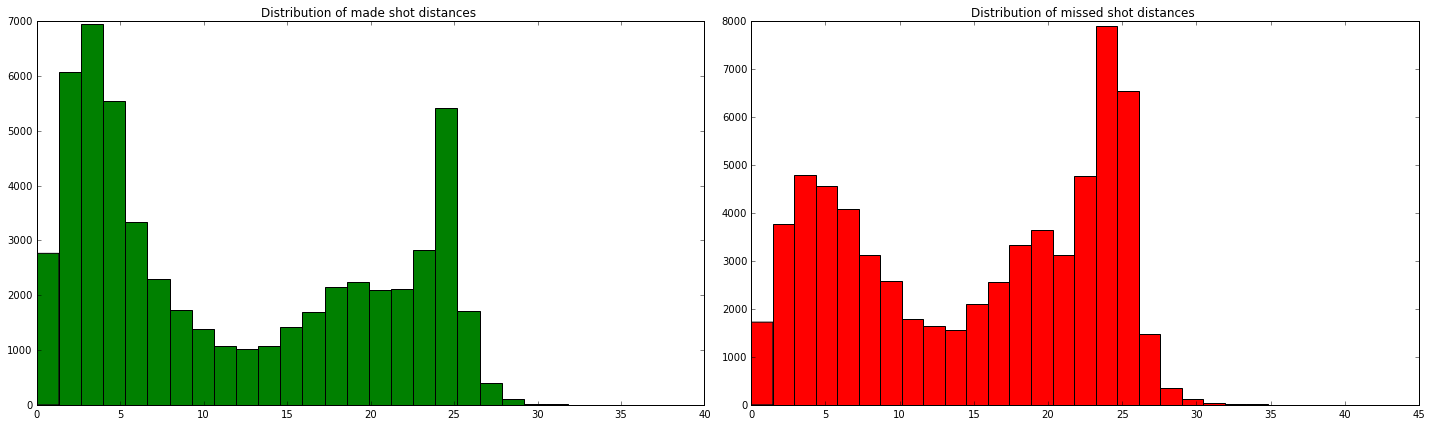

In [90]:
#Plotting shot distances based on whether they were made or missed
subset = data[data['SHOT_RESULT'] == 'made']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(subset['SHOT_DIST'],30, color='green')
ax1.set_title('Distribution of made shot distances ')

subset = data[data['SHOT_RESULT'] == 'missed']
ax2.hist(subset['SHOT_DIST'],30, color='red')
ax2.set_title('Distribution of missed shot distances ')

plt.tight_layout()    
plt.show()

## Part 2

number of unique player ID: 281
number of unique game ID: 896


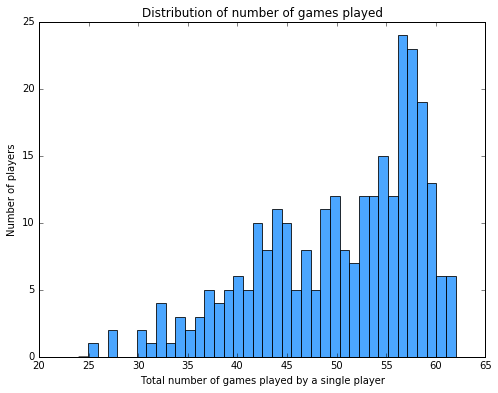

In [91]:
# There are actually data from 281 players
print 'number of unique player ID:', np.unique(data['player_id'].values).shape[0] 
# print 'number of unique player names:', np.unique(data['player_name'].values).shape[0]
player_id = np.unique(data['player_id'].values)
# player_name = np.unique(data['player_name'].values)

# How many unique games are there (should there be 30 * 82 / 2 = 1230 games?)
# Several players may share the same game ID (becuase they all played that night)
print 'number of unique game ID:', np.unique(data['GAME_ID'].values).shape[0]

# Create a dictionary where player_id is the key and all associated unique game IDs are the values
gameID_by_player = {}
for player in player_id:
    gameID_by_player[player] = np.unique(data[data['player_id'] == player]['GAME_ID'])

# games_per_player, in same order as player_id, contains the number of games played by per player
games_per_player = np.array([gameID_by_player[player].shape[0] for player in player_id])
    
# Plot the distribution of number of games played by all players    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

bin_max = games_per_player.max() + 1
bin_min = games_per_player.min() - 1
bins = bin_max - bin_min + 1

ax.hist(games_per_player, bins = bins, range = (bin_min, bin_max), color='dodgerblue', alpha = 0.8)
ax.set_title('Distribution of number of games played')
ax.set_xlabel('Total number of games played by a single player')
ax.set_ylabel('Number of players')
plt.show()

In [92]:
# shots_by_player is a dictionary where player_id is the key and number of shots made per game are the values
# shots_by_player is in the same order as gameID_by_player
shots_by_player = {}
for player in player_id:
    shots_by_player[player] = np.array([data[(data['player_id'] == player) & (data['GAME_ID'] == game)].shape[0] 
                                        for game in gameID_by_player[player]])

In [93]:
print len(shots_by_player.values())

281


(128069, 2)
(281, 2)


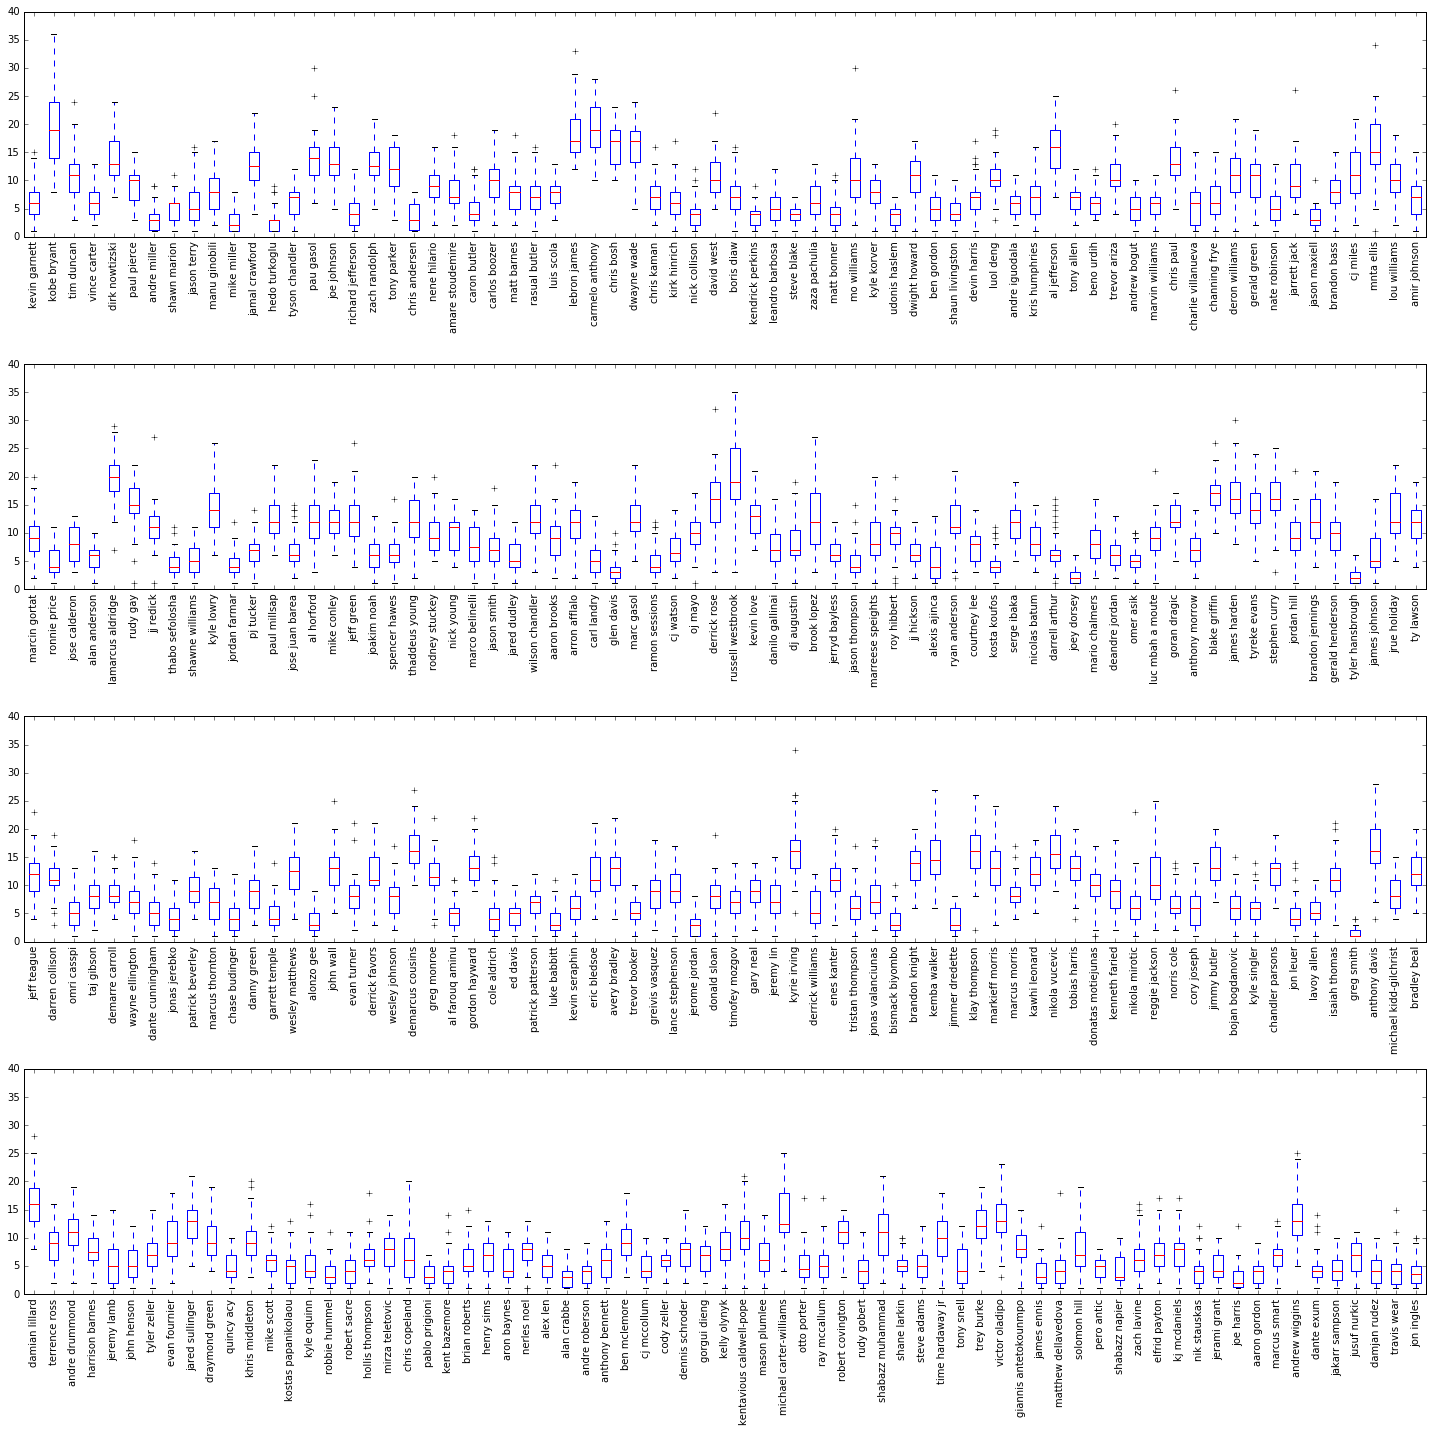

In [95]:
name_id = shots[['player_name', 'player_id']]
print name_id.shape
_, idx = np.unique(name_id['player_id'], return_index=True)
name_id = name_id.loc[idx]
print name_id.shape

# For individual players
fig, ax = plt.subplots(4,1,figsize=(20,20))
ax[0].boxplot([shots_by_player[pid] for pid in player_id[:70]])
ax[0].set_ylim((0,40))
ax[0].set_xticklabels([name_id['player_name'].loc[name_id[name_id['player_id'] == idx].index[0]]
                       for idx in player_id[:70]], rotation='vertical')

ax[1].boxplot([shots_by_player[pid] for pid in player_id[70:140]])
ax[1].set_ylim((0,40))
ax[1].set_xticklabels([name_id['player_name'].loc[name_id[name_id['player_id'] == idx].index[0]]
                       for idx in player_id[70:140]], rotation='vertical')

ax[2].boxplot([shots_by_player[pid] for pid in player_id[140:210]])
ax[2].set_ylim((0,40))
ax[2].set_xticklabels([name_id['player_name'].loc[name_id[name_id['player_id'] == idx].index[0]]
                       for idx in player_id[140:210]], rotation='vertical')

ax[3].boxplot([shots_by_player[pid] for pid in player_id[210:]])
ax[3].set_ylim((0,40))
ax[3].set_xticklabels([name_id['player_name'].loc[name_id[name_id['player_id'] == idx].index[0]]
                       for idx in player_id[210:]], rotation='vertical')

plt.tight_layout()
plt.show()

How many unique shot series do we have?  14165


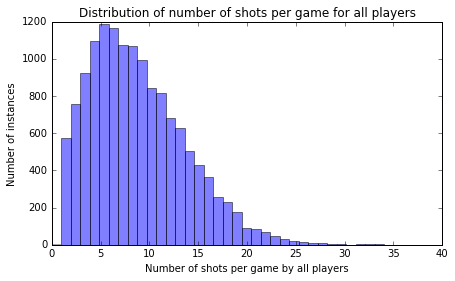

Shoot series with length smaller than 4 comprises: 15.9% of all shot series


In [96]:
# Make an array combining number of shots made per game by all the players
shots_by_all_players = np.array([]).astype(int)
for player in player_id:
    shots_by_all_players = np.append(shots_by_all_players, shots_by_player[player])

# Get the number of unique shot series
print 'How many unique shot series do we have? ', shots_by_all_players.shape[0]
# print sum(games_per_player) # Sanity chekc also 14165

fig, ax = plt.subplots(1, 1, figsize = (7,4))

bin_max = shots_by_all_players.max() + 1
bin_min = shots_by_all_players.min() - 1
bins = bin_max - bin_min + 1

ax.hist(shots_by_all_players, bins = bins, range = [bin_min, bin_max], color = 'b', alpha = 0.5)

ax.set_title('Distribution of number of shots per game for all players')
ax.set_xlabel('Number of shots per game by all players')
ax.set_ylabel('Number of instances')
plt.show()

print 'Shoot series with length smaller than 4 comprises: {:.1f}% of all shot series'.format(
    float(shots_by_all_players[shots_by_all_players < 4].shape[0]) / float(shots_by_all_players.shape[0]) * 100)
# We will throw away 15.9% of shot series

In [97]:
# Make a new column that contains the length of the shot series that the shot is associated with
# This will be useful for filtering purposes

## Testing
# print gameID_by_player[708]
# print int(shots_by_player[708][np.where(gameID_by_player[708] == 21400902)])

# Actual execution
data['shot_series_length'] = [int(shots_by_player[data['player_id'].iloc[i]][np.where(gameID_by_player[data['player_id'].iloc[i]] == data['GAME_ID'].iloc[i])]) for i in range(data.shape[0])]

In [100]:
### Sanity check
# data.iloc[:50]

In [101]:
# Now filter out all the shot series shorter than 4
print data.shape[0]

data = data[data['shot_series_length'] > 4]
print data.shape[0] #results in loss of 10k or so shots

### Sanity check
#data.iloc[:100]

111945
111945


number of unique player ID: 281


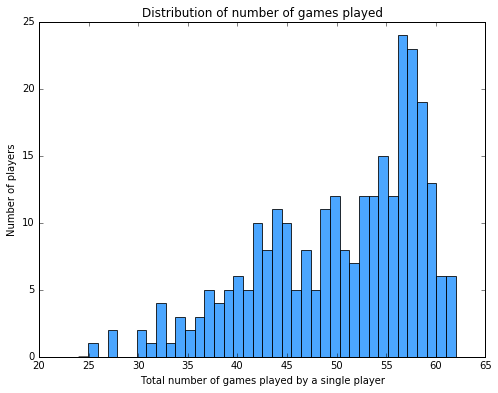

In [12]:
# Did any players drop out after this?

# There are still 280 players. Only one dropped out.
print 'number of unique player ID:', np.unique(data['player_id'].values).shape[0] 

player_id = np.unique(data['player_id'].values)

# Create a dictionary where player_id is the key and all associated unique game IDs are the values
gameID_by_player = {}
for player in player_id:
    gameID_by_player[player] = np.unique(data[data['player_id'] == player]['GAME_ID'])

# games_per_player, in same order as player_id, contains the number of games played by per player
games_per_player = np.array([gameID_by_player[player].shape[0] for player in player_id])
    
# Plot the distribution of number of games played by all players    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

bin_max = games_per_player.max() + 1
bin_min = games_per_player.min() - 1
bins = bin_max - bin_min + 1

ax.hist(games_per_player, bins = bins, range = (bin_min, bin_max), color='dodgerblue', alpha = 0.8)
ax.set_title('Distribution of number of games played')
ax.set_xlabel('Total number of games played by a single player')
ax.set_ylabel('Number of players')
plt.show()

### Should we consider throwing away players with too few shot series because they do not have representative sample size?
### Let's leave it like this and move on for now

## Part 3 - Analysis of Top 5 Players
by Zecai Liang

Based on the filtered data:
1. Generate metrics to evaluate the player's performance (1) PPG = points per game (2) FG% = FGM/FGA = field goals made per game/field goals attempted per game
2. Identify top-5 players* under each criteria, compare between the two different versions of Top 5 lists.
3. For each version of the top-5 players, visualize: (1)the distribution of shot distance among shot_made and shot_missed; (2) number of game played; (3) number of shots made per game; (4) number of shots attempted per game

(* could easily be changed to "Top n Players" with customized parameter ``top_number``, if necessary)

?? Questions for Teammates:
1. When average PPG or FG% among all the games for individual players, is it proper to use mean? 
It may be biased unless we check the distribution of each player.
2. The top-5 list coming from the two criteria are non-overlapping. How do we choose?

In [13]:
data.head(5)

,GAME_ID,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length
0,21400899,1,1,69,10.8,7.7,made,101187,1.3,1,2,203148,8
1,21400899,2,1,14,3.4,28.2,missed,202711,6.1,0,0,203148,8
3,21400899,4,2,707,10.3,17.2,missed,203900,3.4,0,0,203148,8
4,21400899,5,2,634,10.9,3.7,missed,201152,1.1,0,0,203148,8
5,21400899,6,2,495,9.1,18.4,missed,101114,2.6,0,0,203148,8


In [81]:
# set "Top n Player" number
top_number = 5

In [ ]:
### ------------------------------------ 1. Generating Metrics ---------------------------------

# group data by player_id, then by game_id
player_game_group = data.groupby(["player_id","GAME_ID"])

   player_id   GAME_ID  PTS
0        708  21400006   10
1        708  21400033   14
2        708  21400044    6
3        708  21400060    2
4        708  21400075    4
   player_id        PTS
0        708   5.978261
1        977  16.352941
2       1495  10.962264
3       1713   5.333333
4       1717  13.894737

Top 5 Players by PPG criteria:
   index  player_id        PTS
0     27       2544  19.803922
1    132     201939  19.189655
2    105     201566  19.065217
3     28       2546  18.789474
4    187     202691  18.224138


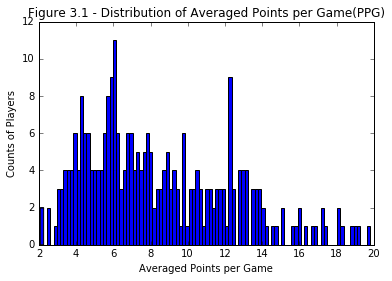

In [134]:
## ------------------------------------ Criteria 1: PPG ----------------------------------------

# points for each game of each player
player_game_ppg = player_game_group["PTS"].sum().reset_index()
print player_game_ppg.head()

# average points among games for each player 
player_ppg = player_game_ppg.groupby("player_id")["PTS"].mean().reset_index()
print player_ppg.head()

# select top n players by PPG
player_ppg_top = player_ppg.sort_values(by="PTS", ascending=False).reset_index()
print "\n", "Top %d Players by PPG criteria:" % top_number
print player_ppg_top.head(int(top_number))

# visualize the distribution of PPG for all the players
plt.hist(player_ppg_top["PTS"], bins=100)
plt.title("Figure 3.1 - Distribution of Averaged Points per Game(PPG)")
plt.xlabel("Averaged Points per Game")
plt.ylabel("Counts of Players")
plt.show()

   player_id   GAME_ID       FG%
0        708  21400006  0.625000
1        708  21400033  0.500000
2        708  21400044  0.375000
3        708  21400060  0.142857
4        708  21400075  0.666667
   player_id       FG%
0        708  0.484849
1        977  0.387361
2       1495  0.507228
3       1713  0.342029
4       1717  0.470222

Top 5 Players by FG criteria:
   index  player_id       FG%
0    124     201599  0.721707
1    252     203497  0.680539
2     13       2199  0.674934
3    164     202334  0.650251
4    173     202366  0.643827


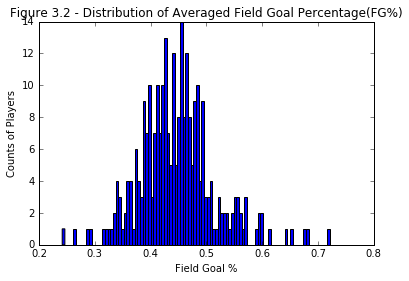

In [136]:
## ------------------------------------ Criteria 2: FG% ----------------------------------------

# FG% for each game of each player
player_game_fg_raw = player_game_group["FGM"].sum() / player_game_group["FGM"].size()
player_game_fg = player_game_fg_raw.reset_index()
player_game_fg.columns.values[2] = "FG%"
print player_game_fg.head()

# average FG% among games for each player 
player_fg = player_game_fg.groupby("player_id")["FG%"].mean().reset_index()
print player_fg.head()

# select top n players by FG%
player_fg_top = player_fg.sort_values(by="FG%", ascending=False).reset_index()
print "\n", "Top %d Players by FG criteria:" % top_number
print player_fg_top.head(int(top_number))

# visualize the distribution of FG% for all the players
plt.hist(player_fg_top["FG%"], bins=100)
plt.title("Figure 3.2 - Distribution of Averaged Field Goal Percentage(FG%)")
plt.xlabel("Field Goal %")
plt.ylabel("Counts of Players")
plt.show()

In [119]:
### ----------------------------  2. Compare Two Versions of Top Lists -------------------------
    # top list by PPG: saved as DataFrame "player_ppg_top"
    # top list by FG%: saved as DataFrame "player_fg_top"

# Extract the Top 5 Players' (by PPG) Ranking under FG% Metrics (the alter_rank starts from 0)
alter_rank_fg = np.array([], dtype="int64")

for player in player_ppg_top["player_id"]:
    rank = player_fg_top[player_fg_top["player_id"] == player].index.values
    alter_rank_fg = np.append(alter_rank_fg,[rank])

player_ppg_top["alter_rank_by_FG"] = alter_rank_fg

print "\n", "Top %d Players by PPG criteria:" % top_number
print player_ppg_top.head(int(top_number))

# Extract the Top 5 Players' (by FG%) Ranking under PPG Metrics (the alter_rank starts from 0)
alter_rank_ppg = np.array([], dtype="int64")

for player in player_fg_top["player_id"]:
    rank = player_ppg_top[player_ppg_top["player_id"] == player].index.values
    alter_rank_ppg = np.append(alter_rank_ppg,[rank])

player_fg_top["alter_rank_by_PPG"] = alter_rank_ppg

print "\n", "Top %d Players by FG criteria:" % top_number
print player_fg_top.head(int(top_number))


Top 5 Players by PPG criteria:
   index  player_id        PTS  alter_rank_by_FG
0     27       2544  19.803922                52
1    132     201939  19.189655                55
2    105     201566  19.065217               135
3     28       2546  18.789474               123
4    187     202691  18.224138               106

Top 5 Players by FG criteria:
   index  player_id       FG%  alter_rank_by_PPG
0    124     201599  0.721707                108
1    252     203497  0.680539                210
2     13       2199  0.674934                120
3    164     202334  0.650251                174
4    173     202366  0.643827                266


We can see from the above chart that the two versions of the Top 5 List varies a lot,
and players who rank high by one criteria don't have high ranking under the other criteria.

In [193]:
### -------------------------------------  3. Visulization --------------------------------------------

## (1) Shot_Distance of Shot_Result_Made and Shot_Result_Missed, for all layers VS top players

    # distance of shot_made, all players
data_shotdist_made = data[data["SHOT_RESULT"] == "made"]["SHOT_DIST"]
     # distance of shot_mmissed, all players
data_shotdist_miss = data[data["SHOT_RESULT"] == "missed"]["SHOT_DIST"]

data_top_ppg = data[data["player_id"].isin(player_ppg_top.head(int(top_number))["player_id"].values)]
    # distance of shot_made, top 5 players by PPG
data_top_ppg_shotdist_made = data_top_ppg[data_top_ppg["SHOT_RESULT"] == "made"]["SHOT_DIST"]
    # distance of shot_missed, top 5 players by PPG
data_top_ppg_shotdist_miss = data_top_ppg[data_top_ppg["SHOT_RESULT"] == "missed"]["SHOT_DIST"]

data_top_fg = data[data["player_id"].isin(player_fg_top.head(int(top_number))["player_id"].values)]
    # distance of shot_made, top 5 players by FG%
data_top_fg_shotdist_made = data_top_fg[data_top_fg["SHOT_RESULT"] == "made"]["SHOT_DIST"]
    # distance of shot_missed, top 5 players by FG%
data_top_fg_shotdist_miss = data_top_fg[data_top_fg["SHOT_RESULT"] == "missed"]["SHOT_DIST"]

Figure 3.3 - The Distribution of Shot Distance:


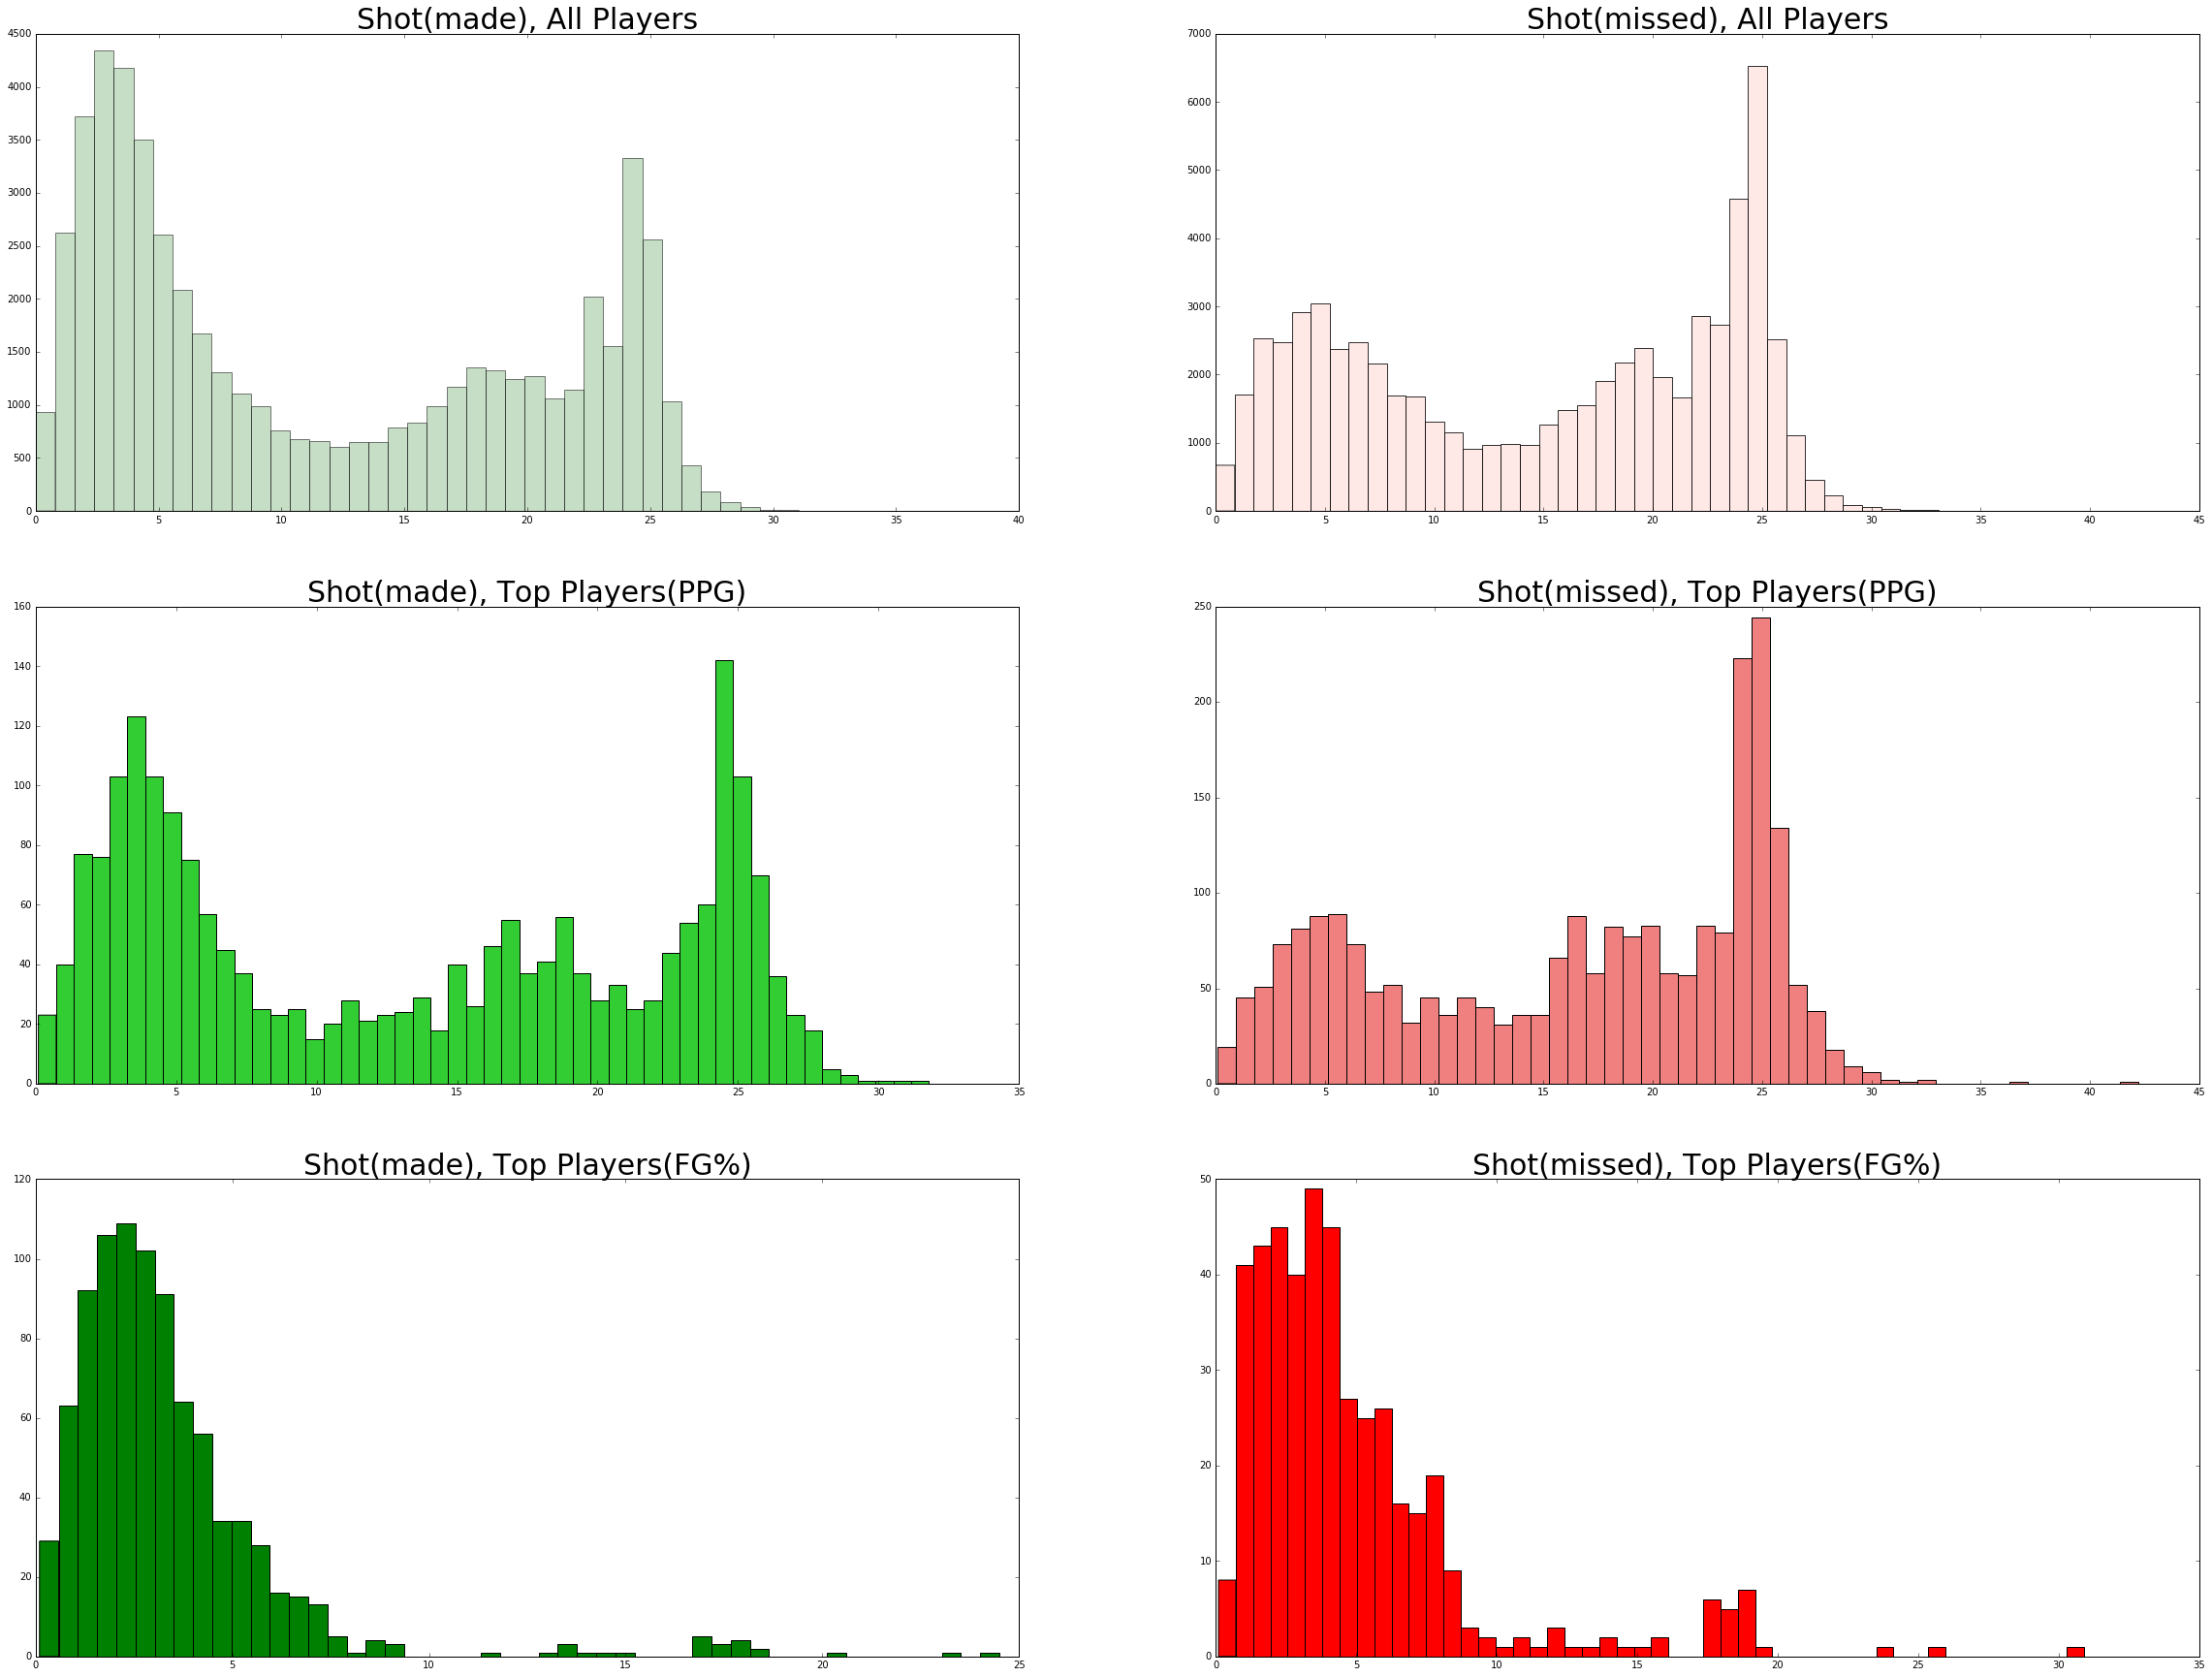

In [202]:
print "Figure 3.3 - The Distribution of Shot Distance:"

fig, ax = plt.subplots(3,2,figsize=(40,30))
ax[0,0].hist(data_shotdist_made, bins=50, color="DarkSeaGreen", alpha=0.5, label="All Players")
ax[0,0].set_title("Shot(made), All Players", fontsize=30)
ax[1,0].hist(data_top_ppg_shotdist_made, bins=50, color="limegreen", label="Top Players by PPG")
ax[1,0].set_title("Shot(made), Top Players(PPG)", fontsize=30)
ax[2,0].hist(data_top_fg_shotdist_made, bins=50, color="green", label="Top Players by FG%")
ax[2,0].set_title("Shot(made), Top Players(FG%)", fontsize=30)

ax[0,1].hist(data_shotdist_miss, bins=50, color="mistyrose", alpha=0.8, label="All Players")
ax[0,1].set_title("Shot(missed), All Players", fontsize=30)
ax[1,1].hist(data_top_ppg_shotdist_miss, bins=50, color="lightcoral", label="Top Players by PPG")
ax[1,1].set_title("Shot(missed), Top Players(PPG)", fontsize=30)
ax[2,1].hist(data_top_fg_shotdist_miss, bins=50, color="red", label="Top Players by FG%")
ax[2,1].set_title("Shot(missed), Top Players(FG%)", fontsize=30)

plt.show()

We can tell from the above visualization that players with high FG% tend to shot from a cloer distance, no matter if the shots are made or missed.

In [205]:
## (2)Number of Game Played, for all layers VS top players

    # number of game played, all players
data_game = data[["player_id","GAME_ID"]].groupby("player_id").size()

    # number of game played, top 5 players by PPG
data_top_ppg_game = data_top_ppg[["player_id","GAME_ID"]].groupby("player_id").size()

    # number of game played, top 5 players by FG%
data_top_fg_game = data_top_fg[["player_id","GAME_ID"]].groupby("player_id").size()

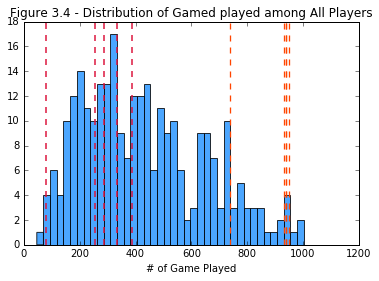

Game Played by the Top Players (PPG), marked by orange:
player_id
2544      933
2546      737
201566    940
201939    938
202691    949
dtype: int64 

Game Played by the Top Players (FG%), marked by red:
player_id
2199      332
201599    386
202334    287
202366     80
203497    255
dtype: int64


In [293]:
plt.hist(data_game, bins=40, color="dodgerblue", alpha=0.8)
plt.title("Figure 3.4 - Distribution of Gamed played among All Players")
plt.xlabel("# of Game Played")
for i in data_top_ppg_game:
    plt.axvline(i, lw=1.3, ls="--", color="orangered")
for i in data_top_fg_game:
    plt.axvline(i, lw=1.5, ls="--", color="crimson")
plt.show()

print "Game Played by the Top Players (PPG), marked by orange:"
print data_top_ppg_game, "\n"

print "Game Played by the Top Players (FG%), marked by red:"
print data_top_fg_game

We can see that the Top 5 Player (by FG%) don't play many games in general.

In [263]:
## (3)FGM (field goal make) per Game, for all layers VS top players (optional)
    # average FGM for all the players
player_game_fgm = player_game_group["FGM"].sum().reset_index()
player_fgm = player_game_fgm.groupby(["player_id"])["FGM"].mean().reset_index()

    # average FGM for top players (by PPG)
player_top_ppg_fgm = player_fgm[player_fgm["player_id"].isin(player_ppg_top.head(int(top_number))["player_id"].values)]

    # average FGM for top players (by FG%)
player_top_fg_fgm = player_fgm[player_fgm["player_id"].isin(player_fg_top.head(int(top_number))["player_id"].values)]

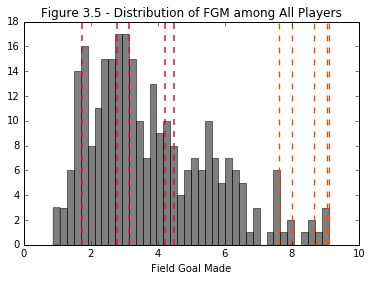

Average FGM for top players (by PPG), marked by orange:
     player_id       FGM
27        2544  9.098039
28        2546  8.657895
105     201566  9.043478
132     201939  8.000000
187     202691  7.620690 

Average FGM for top players (by FG%), marked by red:
     player_id       FGM
13        2199  4.203704
124     201599  4.467742
164     202334  3.122807
173     202366  1.740741
252     203497  2.775862


In [294]:
plt.hist(player_fgm["FGM"], bins=40, color="black", alpha=0.5)
plt.title("Figure 3.5 - Distribution of FGM among All Players")
plt.xlabel("Field Goal Made")
for i in player_top_ppg_fgm["FGM"]:
    plt.axvline(i, lw=1.3, ls="--", color="orangered")
for i in player_top_fg_fgm["FGM"]:
    plt.axvline(i, lw=1.5, ls="--", color="crimson")
plt.show()

print "Average FGM for top players (by PPG), marked by orange:"
print player_top_ppg_fgm,"\n"

print "Average FGM for top players (by FG%), marked by red:"
print player_top_fg_fgm

In [267]:
## (4)FGA (field goal attempted) per Game, for all layers VS top players (optional)

    # average FGA for all the players
player_game_fga = player_game_group["FGM"].size().reset_index()
player_game_fga.columns.values[2] = "FGA"
player_fga = player_game_fga.groupby(["player_id"])["FGA"].mean().reset_index()

    # average FGA for top players (by PPG)
player_top_ppg_fga = player_fga[player_fga["player_id"].isin(player_ppg_top.head(int(top_number))["player_id"].values)]

    # average FGA for top players (by FG%)
player_top_fg_fga = player_fga[player_fga["player_id"].isin(player_fg_top.head(int(top_number))["player_id"].values)]

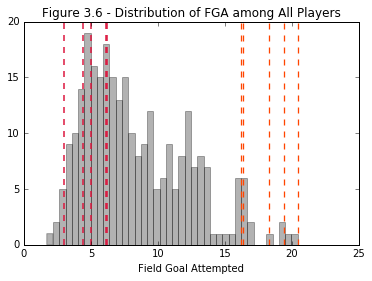

Average FGA for top players (by PPG), marked by orange:
     player_id        FGA
27        2544  18.294118
28        2546  19.394737
105     201566  20.434783
132     201939  16.172414
187     202691  16.362069 

Average FGA for top players (by FG%), marked by red:
     player_id       FGA
13        2199  6.148148
124     201599  6.225806
164     202334  5.035088
173     202366  2.962963
252     203497  4.396552


In [297]:
plt.hist(player_fga["FGA"], bins=40, color="black", alpha=0.3)
plt.title("Figure 3.6 - Distribution of FGA among All Players")
plt.xlabel("Field Goal Attempted")
for i in player_top_ppg_fga["FGA"]:
    plt.axvline(i, lw=1.3, ls="--", color="orangered")
for i in player_top_fg_fga["FGA"]:
    plt.axvline(i, lw=1.5, ls="--", color="crimson")
plt.show()

print "Average FGA for top players (by PPG), marked by orange:"
print player_top_ppg_fga,"\n"

print "Average FGA for top players (by FG%), marked by red:"
print player_top_fg_fga

We can see from the two visualizations above: top players (by FG%) temp to make less FGA and also FGM; while top players (by PPG) top at these two metrics.